# Voting (분류) 기본코드

## #01. 준비작업

### [1] 패키지 가져오기

In [9]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *

# 보팅 분류기
from sklearn.ensemble import VotingClassifier

# 보팅에서 사용할 알고리즘 -> SVC, SGDClassifier는 확률을 제공하지 않으므로 소프트 보팅에는 적용 불가
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [10]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB
None

상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThi

## #02. 데이터 전처리

### [1] 이전 예제에서 수립한 전처리 전략 재현

> `0`값을 포함해서는 안되는 변수에 대해 평균으로 대체

In [11]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [2] 훈련/검증 데이터 분할 및 데이터 표준화

In [12]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #03. 기본 Voting

### [1] Voting에 참여시킬 개별 알고리즘 객체 생성

In [13]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
nb = GaussianNB()
dt = DecisionTreeClassifier()
# svm = SVC()
# sgd = SGDClassifier()

### [2] 개별 모델을 앙상블 모델로 결합

In [14]:
vo = VotingClassifier(
    # 결합할 알고리즘의 리스트 (이름, 알고리즘객체) - 이름은 개발자가 마음대로 지정
    estimators=[('LR', lr), ('KNN', knn), ('NB', nb), ('DT', dt)],
    # hard: 다수결, soft: 확률의 평균
    voting='soft')

# 학습
vo.fit(X=x_train, y=y_train)

# 예측(검증데이터로...)
y_pred = vo.predict(X=x_test)

# 검증 데이터에 대한 정확도
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Voting 분류기 정확도: {score:.4f}')
      
vo

Voting 분류기 정확도: 0.8312


VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('KNN', KNeighborsClassifier()),
                             ('NB', GaussianNB()),
                             ('DT', DecisionTreeClassifier())],
                 voting='soft')

### [3] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.897394 |     0.831169 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |        0.895 |     0.756098 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.809955 |     0.659574 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0534351 |    0.0934579 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.946565 |     0.906542 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.850356 |     0.704545 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.974117 |     0.862398 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

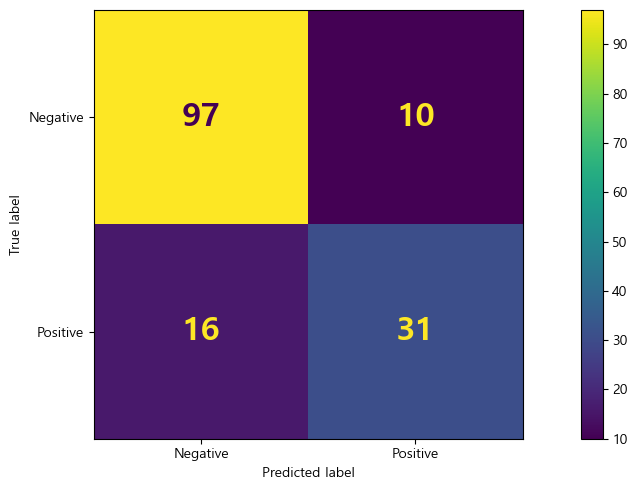


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


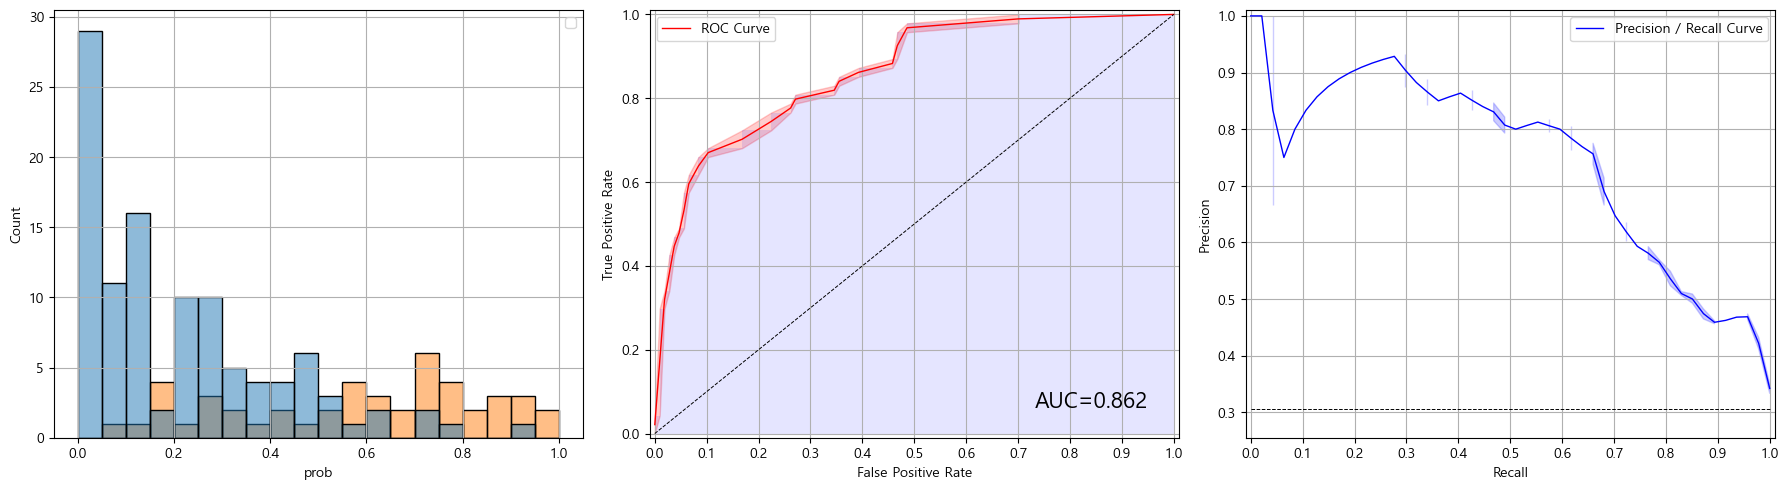


[학습곡선]


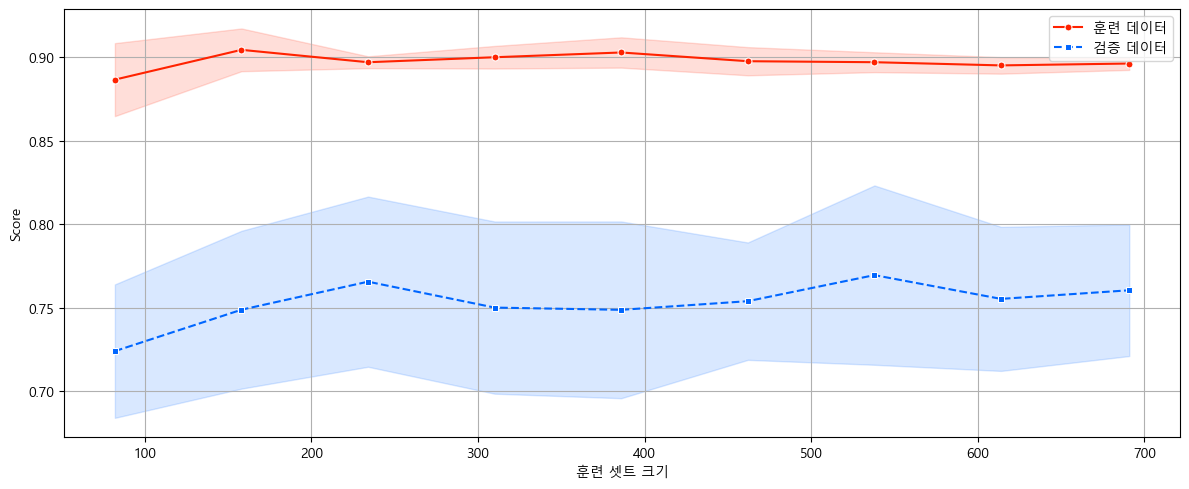

In [15]:
my_classification_result(estimator=vo, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

> 대부분의 앙상블 기법은 대용량 데이터에 대한 처리 기법이므로 샘플수가 적은 경우 과대적합이 매우 잘 발생한다.

### [4] 독립변수 보고

In [16]:
my_classification_report(estimator=vo, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
